# Test time adaptation for a 2d Gaussian model

We use a variant of the example from eqn 2 from the NURD paper,
in which y and z are now binary, with possible values -1,+1.

Generative model:
$$
p(x|y,z) = N(x | [y-bz, y+bz], diag(1.5, 0.5))  \\
p(y) = Ber(0.5) \\
p(z|y) = \rho \text{ if $z=y$}, 1-\rho \text{ otherwise} 
$$

NURD paper:
 A. M. Puli, L. H. Zhang, E. K. Oermann, and R. Ranganath, “Out-of-distribution Generalization in the Presence of Nuisance-Induced Spurious Correlations,” in ICLR, May 2022 [Online]. Available: https://openreview.net/forum?id=12RoR2o32T. 


# Setup

In [2]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -qq git+https://github.com/probml/ssm-jax.git

In [193]:
%reload_ext autoreload

In [194]:
from ssm_jax.misc.labelshift import *



In [16]:
# Silence WARNING:root:The use of `check_types` is deprecated and does not have any effect.
# https://github.com/tensorflow/probability/issues/1523
import logging

logger = logging.getLogger()


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

In [15]:
ys, zs = vmap(mix_to_yz)(jnp.array([0,1,2,3]))
print(ys)
print(zs)

[0 0 1 1]
[0 1 0 1]


# Visualize the likelihood


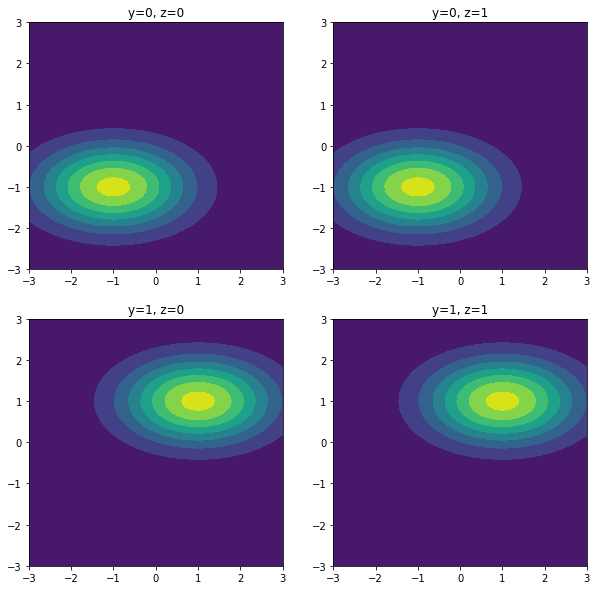

In [25]:
# When b=0, x does not depend on z
lm = LikModel(b=0, sf=1)
lm.plot_class_cond_dist()


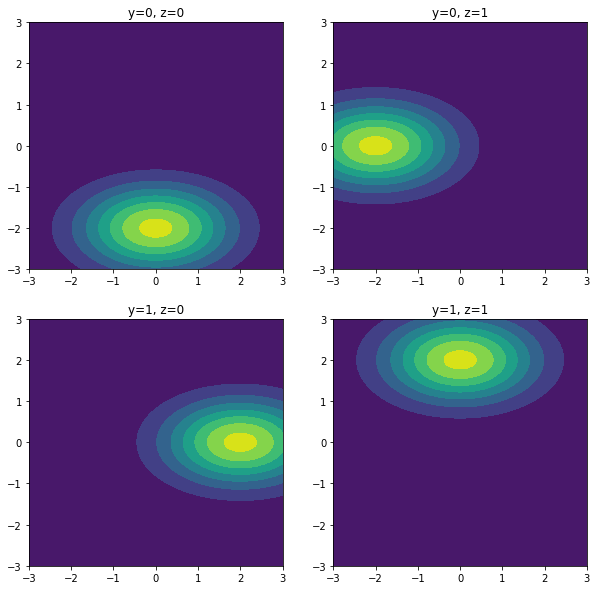

In [24]:
# When sf is small, there is little overlap between the densities
lm = LikModel(b=1, sf=1)
lm.plot_class_cond_dist()


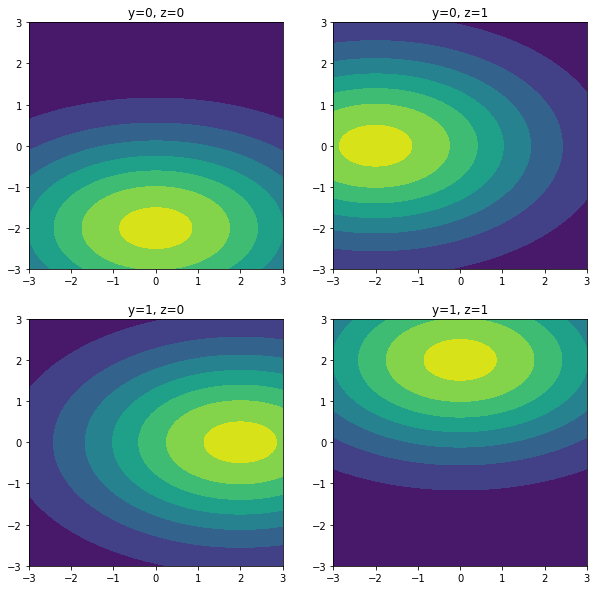

In [26]:
# When sf is large, there is lots of overlap between the densities
lm = LikModel(b=1, sf=5)
lm.plot_class_cond_dist()


# Visualize true posterior

In [51]:
lm = LikModel(b=1, sf=1)
pm = PriorModel(rho = 0.1)
jm = JointModel(lm, pm) 

xs, x1, x2 = make_xgrid(npoints = 100)
print(xs.shape)
mix_post, class_post = jm.predict(xs)
print(mix_post.shape)
print(class_post.shape)



(10000, 2)
(10000, 4)
(10000, 2)


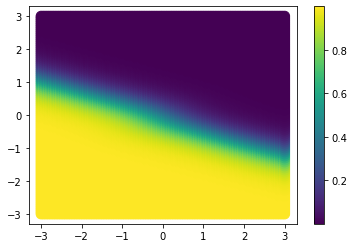

In [52]:

plot_class_post_2d(xs, class_post)


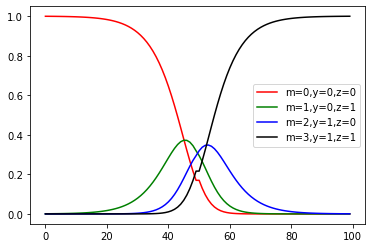

In [50]:
plot_mix_post(mix_post)

# Train model

In [116]:
# Generate data

lm = LikModel(b=1, sf=1)
pm = PriorModel(rho = 0.1)
jm = JointModel(lm, pm)
X_train, mix_train = jm.sample(jr.PRNGKey(42),  500)



In [117]:
# Sanity check

print(X_train.shape)
print(mix_train.shape)

# show some of the data samples
ntrain = X_train.shape[0]
n = np.min([ntrain, 10])
ndx = np.round(np.linspace(1, ntrain-1, num=n)).astype(int)

print(X_train[ndx])
print(mix_train[ndx])

# compute mixture posterior on some of the sampled data
# then derive the MAP estimate for the mix labels
# this should be similar to the sampled mix labels
mix_post, class_post = jm.predict(X_train[ndx])
mix_hat = np.argmax(mix_post, axis=1)
assert np.allclose(mix_train[ndx], mix_hat)



(500, 2)
(500,)
[[-0.69344109 -2.52777982]
 [-1.12092292 -1.95809865]
 [-1.99418712 -1.67337656]
 [ 3.27447057  0.57432437]
 [ 0.34215295 -1.91887772]
 [ 1.21611905 -0.5195815 ]
 [ 0.96468222 -1.21641517]
 [ 0.86976182  0.76760304]
 [-3.10489845  1.07038832]
 [ 0.50583404  0.49537909]]
[0 0 0 2 0 2 0 3 1 3]


In [121]:
model = Estimator_Lik_Logreg_Prior_EM()
model.fit_source(X_train, mix_train)


# Evaluate source fit

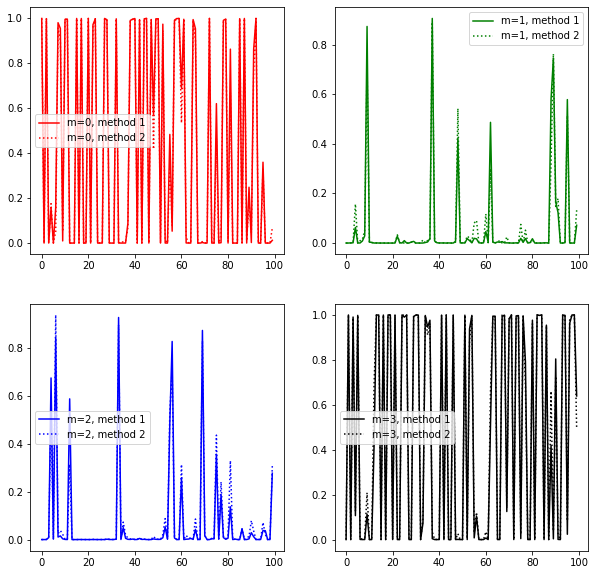

In [122]:
# Evaluate on training set

mix_post_true, class_post_true = jm.predict(X_train)
mix_post_pred, class_post_pred = model.predict_source(X_train)
plot_mix_post_pair(mix_post_true, mix_post_pred)

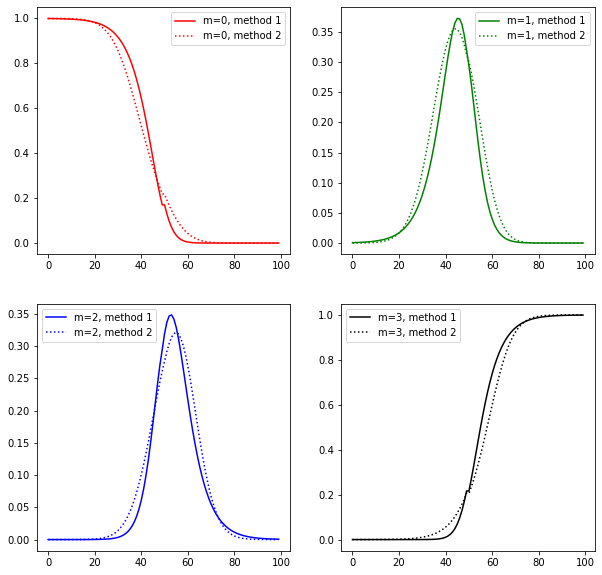

In [123]:
# Evaluate on test grid
xs, x1, x2 = make_xgrid(npoints = 100)

mix_post_true, class_post_true = jm.predict(xs)
mix_post_pred, class_post_pred = model.predict_source(xs)

plot_mix_post_pair(mix_post_true, mix_post_pred)


# Distribution shift



In [124]:
# Use EM on source distribution, as a sanity check

lm = LikModel(b=1, sf=1)
pm_source = PriorModel(rho = 0.1)
print(pm_source.prior_probs)
jm_source = JointModel(lm, pm_source)
X_train_source, mix_train_source = jm_source.sample(jr.PRNGKey(42),  500)

model = Estimator_Lik_Logreg_Prior_EM()
model.fit_source(X_train_source, mix_train_source)
print(model.prior_source)
model.fit_target(X_train_source) # fit prior on  source distribution
print(model.prior_target)

[0.45 0.05 0.05 0.45]
[0.43399878 0.04999922 0.0600006  0.4560014 ]
[0.43397157 0.05002725 0.06002554 0.45597564]


In [125]:
# Use EM on target distribution

pm_target = PriorModel(rho = 0.2)
print(pm_target.prior_probs)
jm_target = JointModel(lm, pm_target)
X_train_target, mix_train_target = jm_target.sample(jr.PRNGKey(42),  500)

model.fit_target(X_train_target) 
print(model.prior_target)

[0.4 0.1 0.1 0.4]
[0.37882771 0.08680462 0.13875644 0.39561123]


In [126]:

pm_target = PriorModel(rho = 0.5)
print(pm_target.prior_probs)
jm_target = JointModel(lm, pm_target)
X_train_target, mix_train_target = jm_target.sample(jr.PRNGKey(42),  500)

model.fit_target(X_train_target) 
print(model.prior_target)

[0.25 0.25 0.25 0.25]
[0.23455834 0.2569768  0.24635329 0.26211157]


# Evaluation

EM
TruePrior
SourceUnadapted
UnifSourceUnadapted


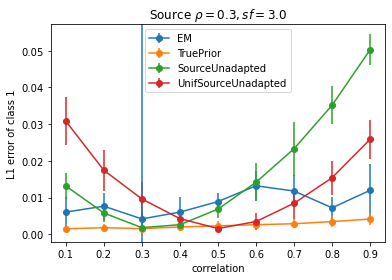

In [195]:
run_expt(rho_source=0.3, ntrials=3, sf=3)